# Segmenting Credit Card Customers using K-means

For this project, we will act as a data scientist at a credit card company and bring insight about our customers to various business stakeholders. Stakeholders are us to group our customer base into various groups and general trends about each group. 

#### Exploratory Data Analysis 

In [1]:
#Importing libraries 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

#Reading csv into pd Dataframe 

#Some general exploration of our data to familiarize ourself 
customers = pd.read_csv('customer_segmentation.csv')
print(customers.head(), '\n')
print(f'Number of features: {customers.shape[1]}','\n')
print(f'Number of observations: {customers.shape[0]}','\n')
print(customers.dtypes, '\n')
print(customers.isna().sum())

   customer_id  age gender  dependent_count education_level marital_status  \
0    768805383   45      M                3     High School        Married   
1    818770008   49      F                5        Graduate         Single   
2    713982108   51      M                3        Graduate        Married   
3    769911858   40      F                4     High School        Unknown   
4    709106358   40      M                3      Uneducated        Married   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   
2             93000              36                         4   
3             37000              34                         3   
4             65000              21                         5   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1             

From initial exploration, we have 10127 observations and 14 features. Additionally, we have 3 categorical variables and 11 continuous variables. However, we have one feature, customer_id, that is a unique identifier that should not be used for our analysis since it does not provide any actionable insights on our population. 

We also do not have any missing variables, therefore, we do not have to fill any values. 

#### Data Dictionary 
- customer_id: unique identifier for each customer.
- age: customer age in years.
- gender: customer gender (M or F).
- dependent_count: number of dependents of each customer.
- education_level: level of education ("High School", "Graduate", etc.).
- marital_status: marital status ("Single", "Married", etc.).
- estimated_income: the estimated income for the customer projected by the data science team.
- months_on_book: time as a customer in months.
- total_relationship_count: number of times the customer contacted the company.
- months_inactive_12_mon: number of months the customer did not use the - credit card in the last 12 months.
- credit_limit: customer's credit limit.
- total_trans_amount: the overall amount of money spent on the card by the customer.
- total_trans_count: the overall number of times the customer used the card.
- avg_utilization_ratio: daily average utilization ratio.

#### Correlation 
We are going to observe the variables using a Pearson's correlation coefficient to see if there are any relationships that stand out to us. 

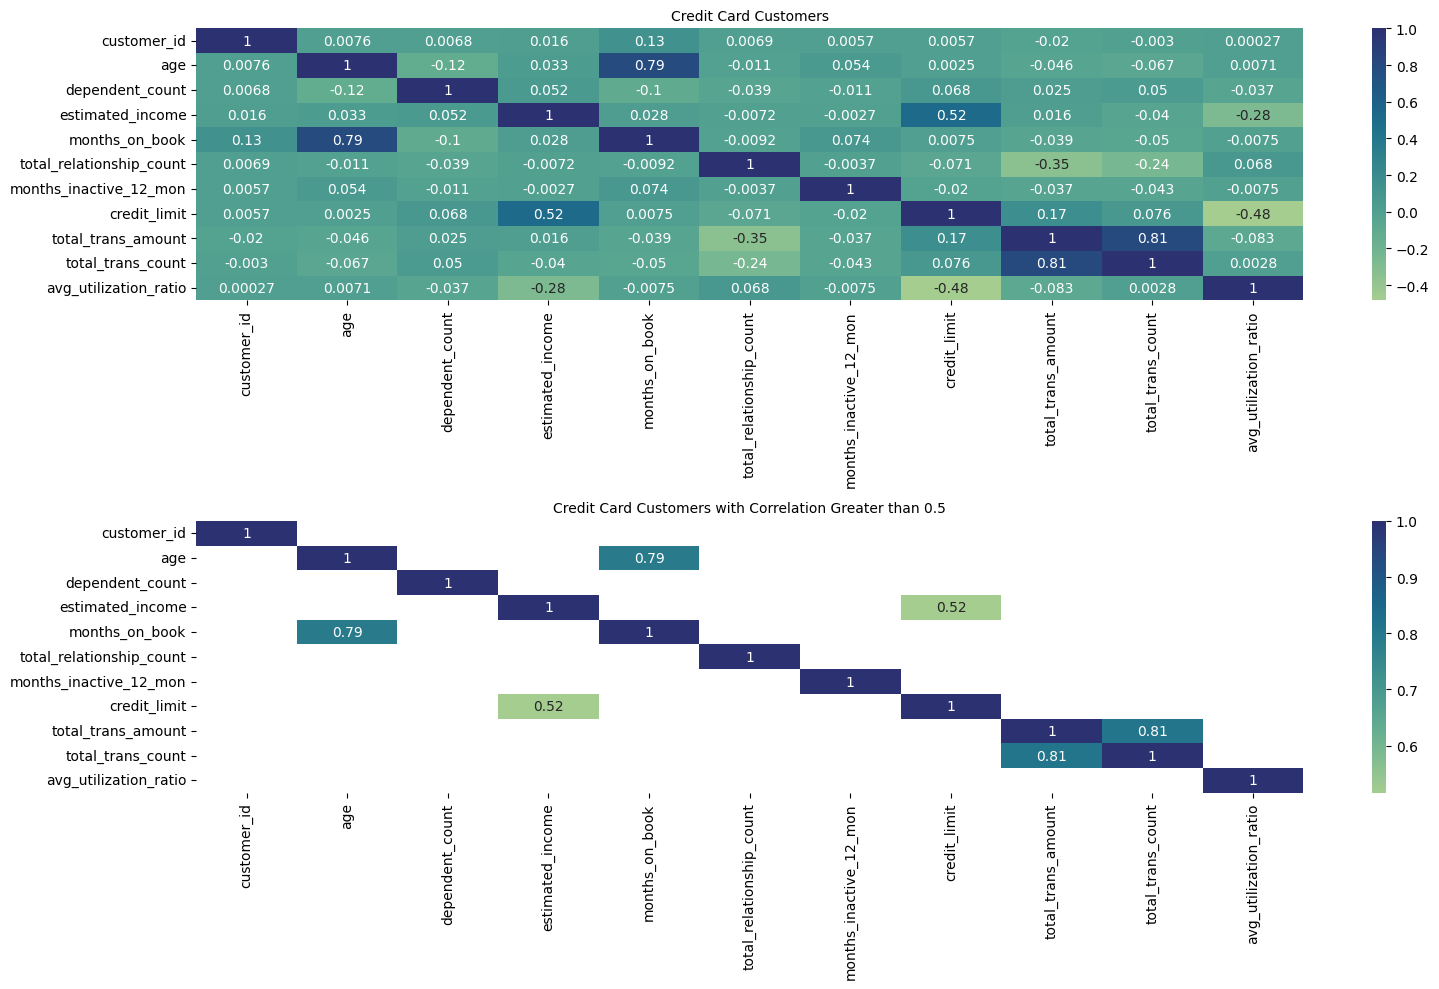

In [2]:
#Observing any strong correlations
fig, axes = plt.subplots(2, 1, figsize=(16,10))
axes = axes.flatten()
cust_corr = customers.corr()
sns.heatmap(cust_corr, ax = axes[0], cmap="crest", annot = True)
axes[0].set_title("Credit Card Customers", fontsize=10)
sns.heatmap(cust_corr[cust_corr > 0.5], ax = axes[1], cmap="crest", annot = True)
axes[1].set_title("Credit Card Customers with Correlation Greater than 0.5", fontsize=10)
plt.tight_layout()
plt.show()

From the above heatmaps, we have three strong positively correlated relationships that we can possibly explore later: 
- age vs months on books 
- estimated income vs credit limit 
- total_trans_amount vs total_trans_count

#### Data Cleaning

Now that we have explored out data and observed potential relationships we may be interested in, we are going to prepare our data for our model. 

There are 3 categorical variables as mentioned before: gender, education level and marital status. We are first going to create a copy of our original dataframe and change the categorical observations in the education level and gender into numerical values. 

In [3]:
#Create copy of dataframe 
customers_copy = customers.copy()

#Map values into numerical values 

customers_copy['gender'] = customers_copy['gender'].map({'M': 1, 'F': 0})
customers_copy['education_level'] = customers_copy['education_level'].map({'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate':4, 'Doctorate':5})

#Check values 
print(customers_copy[['gender', 'education_level']].head())

   gender  education_level
0       1                1
1       0                3
2       1                3
3       0                1
4       1                0


We cannot use the same methods for martial status since there are four unique values and we cannot rank them from least to greatest since this is not an ordinal variable. Therefore, we are going to create dummy columns from the marital status column, concat these columns to the copied dataframe, and finally drop the marital status column from the copied dataframe. 

In [4]:
# Create dummy variables for the 'marital_status' column
dummies = pd.get_dummies(customers_copy['marital_status'], prefix='marital_status')

# Join the dummy variables with the original DataFrame
customers_copy = pd.concat([customers_copy, dummies], axis=1)

# Drop the original 'Category' column if needed
customers_copy = customers_copy.drop('marital_status', axis=1)

In [5]:
#Like said earlier, customer_id is not actionable so we will drop it 
customers_copy = customers_copy.drop(columns=['customer_id'])

Now that we have prepped the categorical variables into numerical variables, we need to ensure we scale our data as there are variables whose ranges vary drastically. We can do this by instantiating a scaler class and using our copied dataframe to scale the data. 

Because the scaler is an array, we can transform this array back into a DataFrame.

In [6]:
scaler = StandardScaler()
scaler.fit(customers_copy) 
scaled_customers = scaler.transform(customers_copy) 
print(scaled_customers)
scaled = pd.DataFrame(scaled_customers)

[[-0.16540558  1.05995565  0.50336813 ...  1.07733799 -0.79850685
  -0.28260887]
 [ 0.33357038 -0.9434357   2.04319867 ... -0.92821381  1.2523374
  -0.28260887]
 [ 0.58305837  1.05995565  0.50336813 ...  1.07733799 -0.79850685
  -0.28260887]
 ...
 [-0.29014957 -0.9434357  -1.03646242 ...  1.07733799 -0.79850685
  -0.28260887]
 [-2.03656544  1.05995565 -0.26654715 ... -0.92821381 -0.79850685
   3.53845931]
 [-0.41489356 -0.9434357  -0.26654715 ...  1.07733799 -0.79850685
  -0.28260887]]


Now our dataset is finally ready for machine learning and our model. We need to determine what is the optimal number of clusters for segmentation. Therefore, we will use the elbow rule to balance the lowest number of clusters as well as the lowest sum of inertia. 

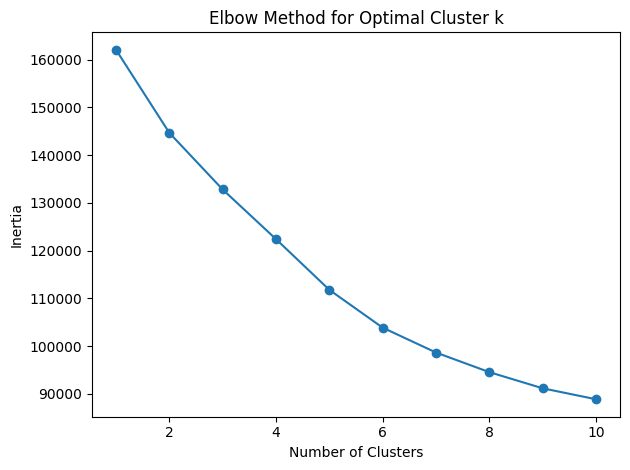

In [7]:
inertias = [] 
for k in range(1, 11):
    model = KMeans(n_clusters=k) 
    cluster = model.fit_predict(scaled)
    inertias.append(model.inertia_)

plt.plot(range(1, 11), inertias, marker='o') 
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster k')
plt.tight_layout()
plt.show()

Observing the rate of inertia decreasing, we notice that inertia starts to decrease a smaller rate at approximately 6 clusters, therefore, we will use 6 clusters to instantiate a new KMeans model and use those values to determine where each observation belongs. 

In [8]:
model = KMeans(n_clusters = 6) 
prediction = model.fit_predict(scaled)
print(prediction)

[1 4 1 ... 0 3 0]


We are going to append our cluster prediction as a new column to our original dataframe. We will add 1 so that our values frame from 1-6. 

In [9]:
customers['Cluster'] = prediction + 1

#### Data Visualization

Now that we have a cluster column in our original dataframe, we can group the various numeric columns by cluster and determine each subgroup's average in order to make comparisons for our data. We can then view them each in a bar chart to better analyze any trends. 

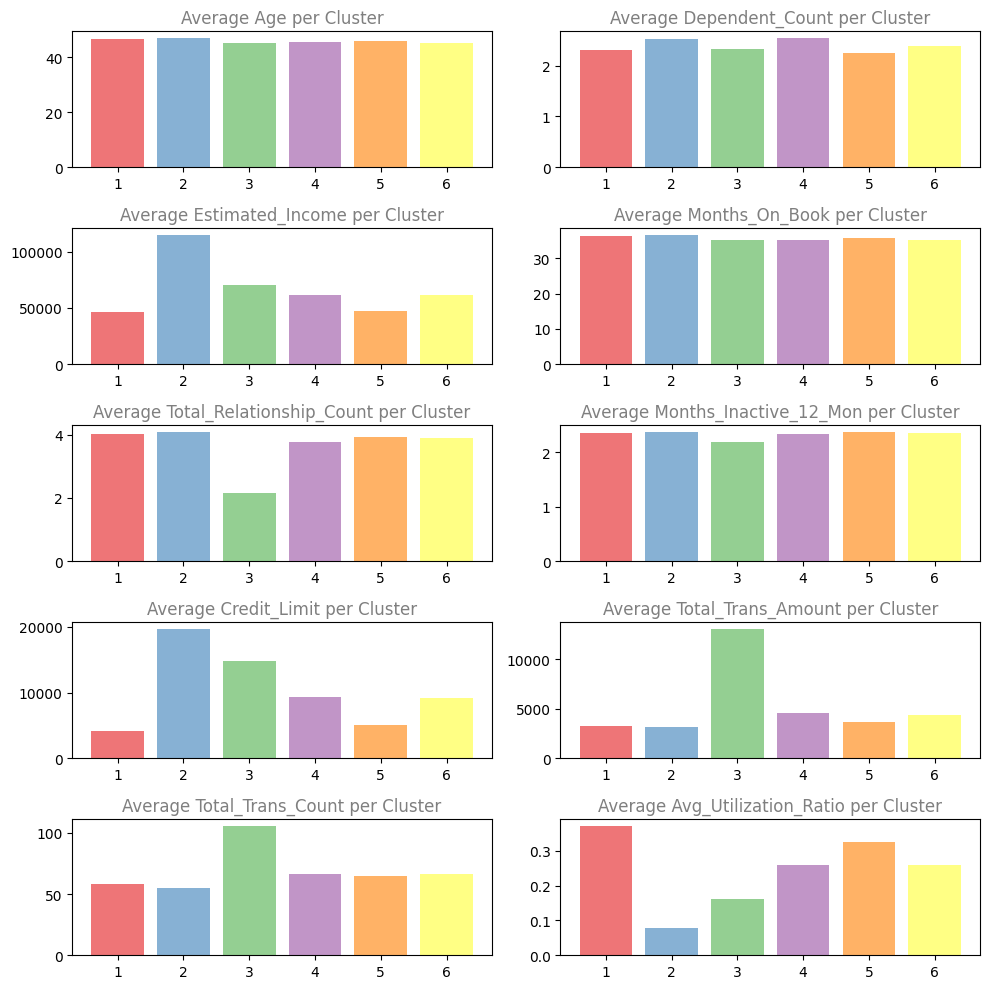

In [10]:
numeric_columns = ['age', 'dependent_count', 'estimated_income', 'months_on_book', 
                   'total_relationship_count', 'months_inactive_12_mon', 'credit_limit', 
                   'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']

fig, axes = plt.subplots(5, 2, figsize =(10,10)) 
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('Cluster')[column].mean()
    axes[i].bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    axes[i].set_title(f'Average {column.title()} per Cluster', alpha=0.5)

#Spruce up our figures 
plt.tight_layout()
plt.show()

Earlier we pointed out there were three positively correlated relationships that we could dive deeper into. Now, that we have cluster groups, we can view these relationships on a scatterplot colored by cluster. 

The three relationships were: 
- age vs months_on_book
- estimated income vs credit limit
- total_trans_amount vs total_trans_count

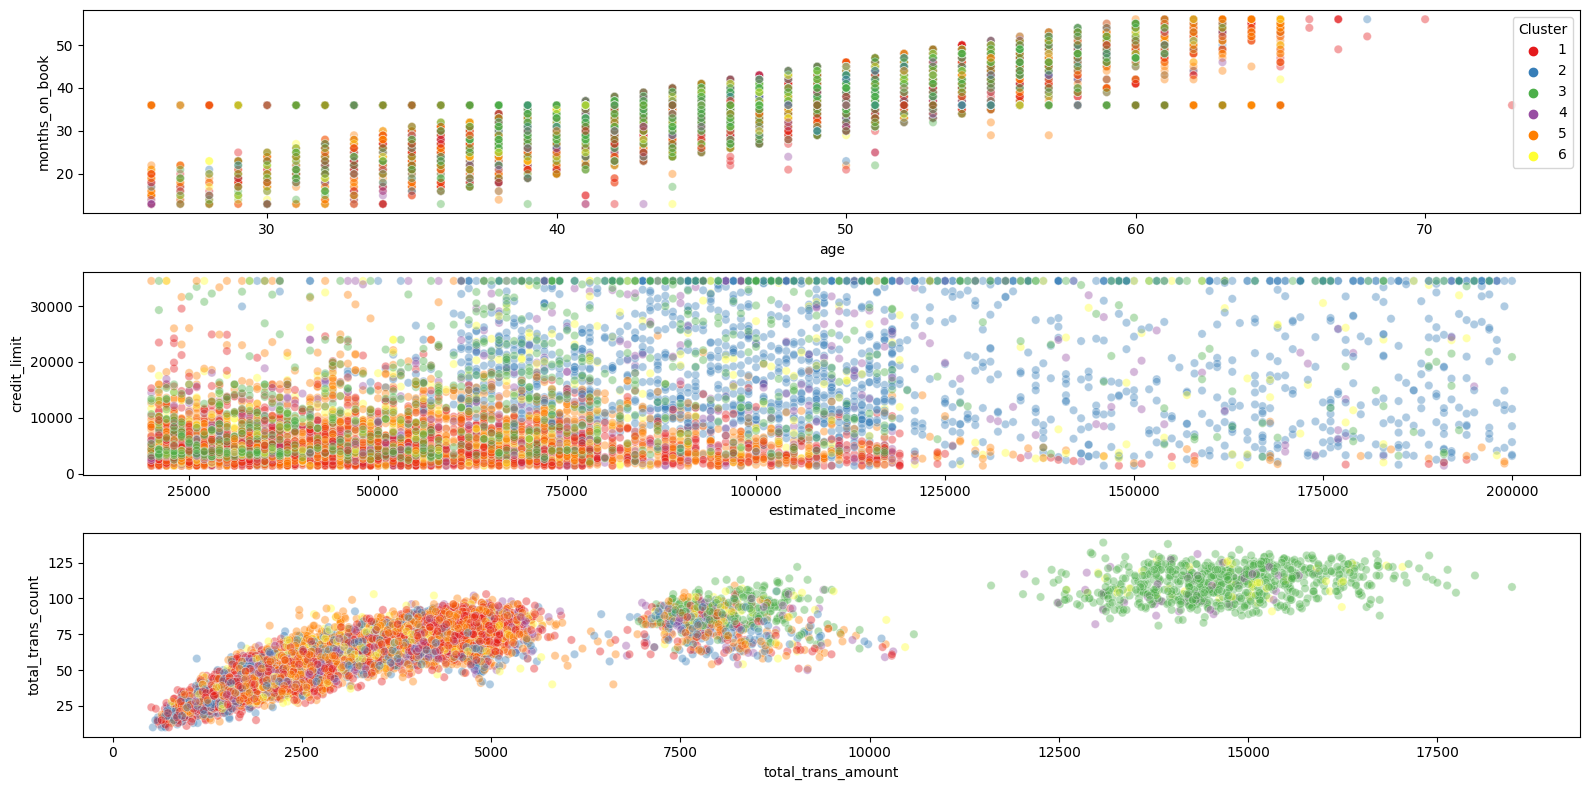

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8))
axes = axes.flatten()
sns.scatterplot(x='age', y='months_on_book', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axes[0])
sns.scatterplot(x='estimated_income', y='credit_limit', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axes[1], legend = False)
sns.scatterplot(x='total_trans_amount', y='total_trans_count', hue='Cluster', data=customers, palette='Set1', alpha=0.4, ax=axes[2], legend = False)
plt.tight_layout()
plt.show()

Finally, we can observe the relationships of the categorical variables by cluster by using a stacked bar chart.

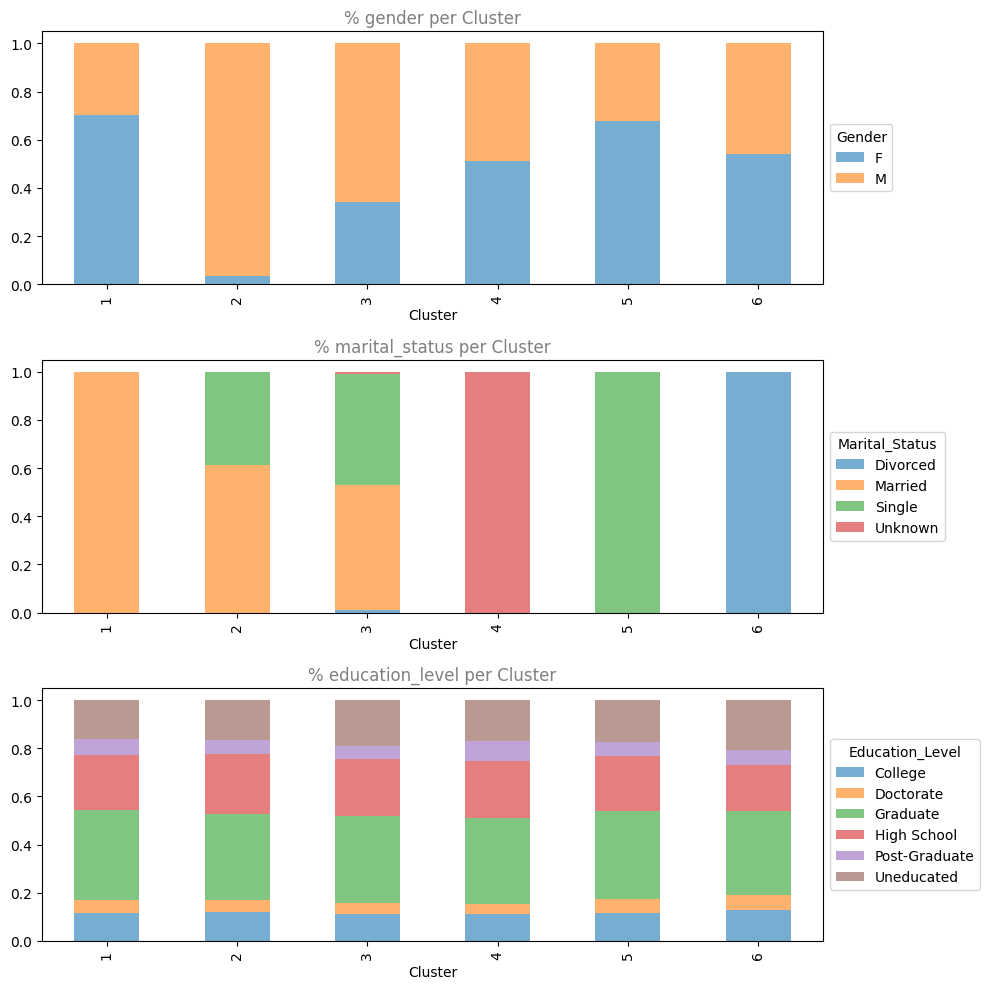

In [12]:
categorical_columns = ['gender', 'marital_status', 'education_level']
fig, axes = plt.subplots(3, 1, figsize=(10,10))
axes = axes.flatten()

for i, column in enumerate(categorical_columns): 
    plot_df = pd.crosstab(
      index=customers['Cluster'], columns=customers[column],
      values=customers[column], aggfunc='size', normalize='index'
    )
    plot_df.plot.bar(stacked=True, ax=axes[i], alpha=0.6, legend = 'upper right')
    axes[i].set_title(f'% {column} per Cluster', alpha=0.5)
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), title=column.title())

plt.tight_layout()
plt.show()

From the modeling and visualization we completed here are the trends that we observe for each cluster group: 

1. Cluster Group 1 
    - Consists mostly of married women 
    - Lowest income compared to rest of the clusters
    - Lowest credit limit compared to rest of the clusters  
    - Highest average utilization ratio compared to rest of the clusters 
2. Cluster Group 2 
     - Consists mostly of married men 
     - Highest income compared to rest of the clusters
     - Highest credit limit compared to rest of the clusters 
     - Lowest average utilization ratio compared to rest of the clusters
3. Cluster Group 3 
    - Consists mostly of men evenly split between married and single 
    - Highest total transaction amount compared to rest of the clusters
    - Highest total transaction count compared to rest of the clusters
    - Lower average utilization ratio compared to rest of the clusters
4. Cluster Group 4
    - Even gender split with unknown marital status 
    - Median credit limit 
    - Median income compared to rest of the clusters
    - Median transaction amount compared to rest of the clusters
    - Median transaction count compared to rest of the clusters
5. Cluster Group 5
    - Consists mostly of single women 
    - Low credit limit compared to rest of the clusters 
    - Low income compared to rest of the clusters 
    - High average utilization ratio compared to rest of the clusters 
6. Cluster Group 6
    - Even gender split and divorced
    - Median credit limit compared to rest of the clusters 
    - Median income compared to rest of the clusters 
    - Median transaction count and amount 
    - Median average utilization ratio 


#### Conclusion

Based on our findings, there are a couple groups that may be worthwhile to take action on: clusters 1, 3, and 5 do not have high incomes, yet they seem to either have high utilization ratio,  so they are using their card often, or they have high transaction amounts, so they have expensive purchases. 

These groups should be observed on a more granular level to see if they are paying off their credit cards on time and what is their current amount owed. This is to ensure these groups do not lose the company any income. 

On the flip side, cluster group 2 has a very high income and limit, but few and inexpensive purchases. Therefore, this group may need extra incentives or bonuses in order to get them to start spending more. 